In [24]:
from ephysvibe.structures.neuron_data import NeuronData
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import glob
from ephysvibe.trials import align_trials,select_trials
from ephysvibe.trials.spikes import firing_rate
import platform
from ephysvibe.task import task_constants
from joblib import Parallel, delayed
from tqdm import tqdm
import h5py
from pathlib import Path
from typing import Dict,List
from scipy import stats

### Def functions

In [25]:
def plot_raster_conv(sp_sample,start,conv,time,ax1,ax2,colors):
    n_trials=0
    for key,sp in sp_sample.items():
        # ----- plot conv----------
        ax1.plot(time, conv[key], color=colors[key])
        # ----- plot spikes----------
        rows, cols = np.where(sp >= 1)
        ax2.scatter(cols+start,rows+n_trials, marker='|', alpha=1,edgecolors='none',color=colors[key],label="sample %s" % key)
        n_trials = n_trials + sp.shape[0] 

    return ax1,ax2,n_trials

In [26]:
def conv_mean_trials_fr(arr,fs = 1000,w_size=0.1,w_std=0.015):
    # define kernel for convolution
    kernel = firing_rate.define_kernel(
        w_size, w_std, fs=fs
    )
    mean_arr = arr.mean(axis=0)
    conv = np.convolve(mean_arr, kernel, mode="same") * fs
    return conv

### Start analysis

In [27]:
if platform.system() == 'Linux':
    basepath = '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/'
elif platform.system() == 'Windows':
    basepath = 'C:/Users/camil/Documents/int/'

In [28]:
area='lip'
neu_path = basepath+'/session_struct/'+area+'/neurons/*neu.h5'
path_list = glob.glob(neu_path)

#### Select parameters

In [29]:
# parameters
# Load data
n_test=0
time_before=500
start=-200
end_test = n_test*450+200
end=450+200+200+end_test
idx_start = time_before + start 
idx_end = time_before+end
# ---conv
fs = 1000
w_size=0.1
w_std=0.015
# Timings 
## fixation
dur_fix = 200
## visual stim
st_v =   80
end_v = 300
## delay
st_d = 600 
end_d = 800
# trials and threshold
min_trials = 3
n_spikes = 1
p_threshold = 0.05
vd_threshold = 0.4

In [30]:
neu_data = NeuronData.from_python_hdf5(path_list[0])

In [46]:
path_list[0]

'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure//session_struct/lip/neurons/2022-12-01_10-23-18_Riesling_lip_e1_r1_good1_neu.h5'

In [31]:
conv_all={}
all_sp_by_sample = {}
count_trials=0
all_max_conv=0
all_max_trial=0

In [32]:
select_block=1
code=1
idx_start = time_before + start 
idx_end = time_before+end
# Select trials aligned to sample onset
sp_sample_on, mask = align_trials.align_on(
    sp_samples=neu_data.sp_samples,
    code_samples=neu_data.code_samples,
    code_numbers=neu_data.code_numbers,
    trial_error=neu_data.trial_error,
    block=neu_data.block,
    pos_code=neu_data.pos_code,
    select_block= select_block,
    select_pos= code,
    event ="sample_on",
    time_before = time_before,
    error_type= 0,
) 
sample_id = neu_data.sample_id[mask]

In [33]:
def plot_activity(sp_by_sample,start,end,conv_all):
    fig, ax = plt.subplots(figsize=(25, 10), sharey=True)
    time = np.arange(0,end-start)+start
    ax_2 = ax.twinx()
    ax, ax_2,n_trials_in=plot_raster_conv(sp_by_sample,start,conv_all,time,ax,ax_2,colors=task_constants.PALETTE_B1)
    all_max_trial=n_trials_in
    # -----parameters in plot
    ax_2.axes.set_yticks(np.arange(-all_max_conv-5, all_max_trial))
    ax.axes.set_ylim(0,all_max_conv+all_max_trial+5)
    ax.axes.set_yticks(np.arange(0, all_max_conv+5,10))
    plt.setp(ax_2.axes.get_yticklabels(), visible=False)
    plt.setp(ax_2.axes.get_yaxis(), visible=False)
    ax.set_title('in',fontsize=15)
    ax.vlines(
            [0,450,900],
            0,
            all_max_conv+all_max_trial+5,
            color='k',
            linestyles="dashed",
        )
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax_2.spines["right"].set_visible(False)
    ax_2.spines["top"].set_visible(False)
    ax.set_xlabel(xlabel="Time (ms)",fontsize=18)
    ax.set_ylabel(ylabel="Average firing rate",fontsize=15,loc="bottom")
    for xtick in ax.xaxis.get_major_ticks():
        xtick.label1.set_fontsize(15)  
    for ytick in ax.yaxis.get_major_ticks():
        ytick.label1.set_fontsize(15) 
    for xtick in ax_2.xaxis.get_major_ticks():
        xtick.label1.set_fontsize(15) 
    ## --- figure
    fig.tight_layout(pad=0.2, h_pad=0.2, w_pad=0.8)
    fig.suptitle("%s: %s %s %d " % (neu_data.date_time, neu_data.area, neu_data.cluster_group, neu_data.cluster_number), x=0.05, y=0.99,fontsize=15)

### All trials

In [34]:
0.015*1000

15.0

In [35]:
0.05*1000

50.0

In [36]:
sp_by_sample = select_trials.get_sp_by_sample(sp_sample_on,sample_id)
for key,value in sp_by_sample.items():
    arr = value.mean(axis=0)
    conv = firing_rate.convolve_signal(arr=arr,fs = 1000,w_size=0.1,w_std=0.015,axis=0)[idx_start:idx_end]
    conv_all[key] = conv
    sp_by_sample[key]=value[:,idx_start:idx_end]
    count_trials= value.shape[0]
    max_conv = np.max(conv) 
    all_max_conv = max_conv if max_conv > all_max_conv else all_max_conv
    all_max_trial = count_trials if count_trials > all_max_trial else all_max_trial

/tmp/ipykernel_7258/1953733509.py:8: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(cols+start,rows+n_trials, marker='|', alpha=1,edgecolors='none',color=colors[key],label="sample %s" % key)


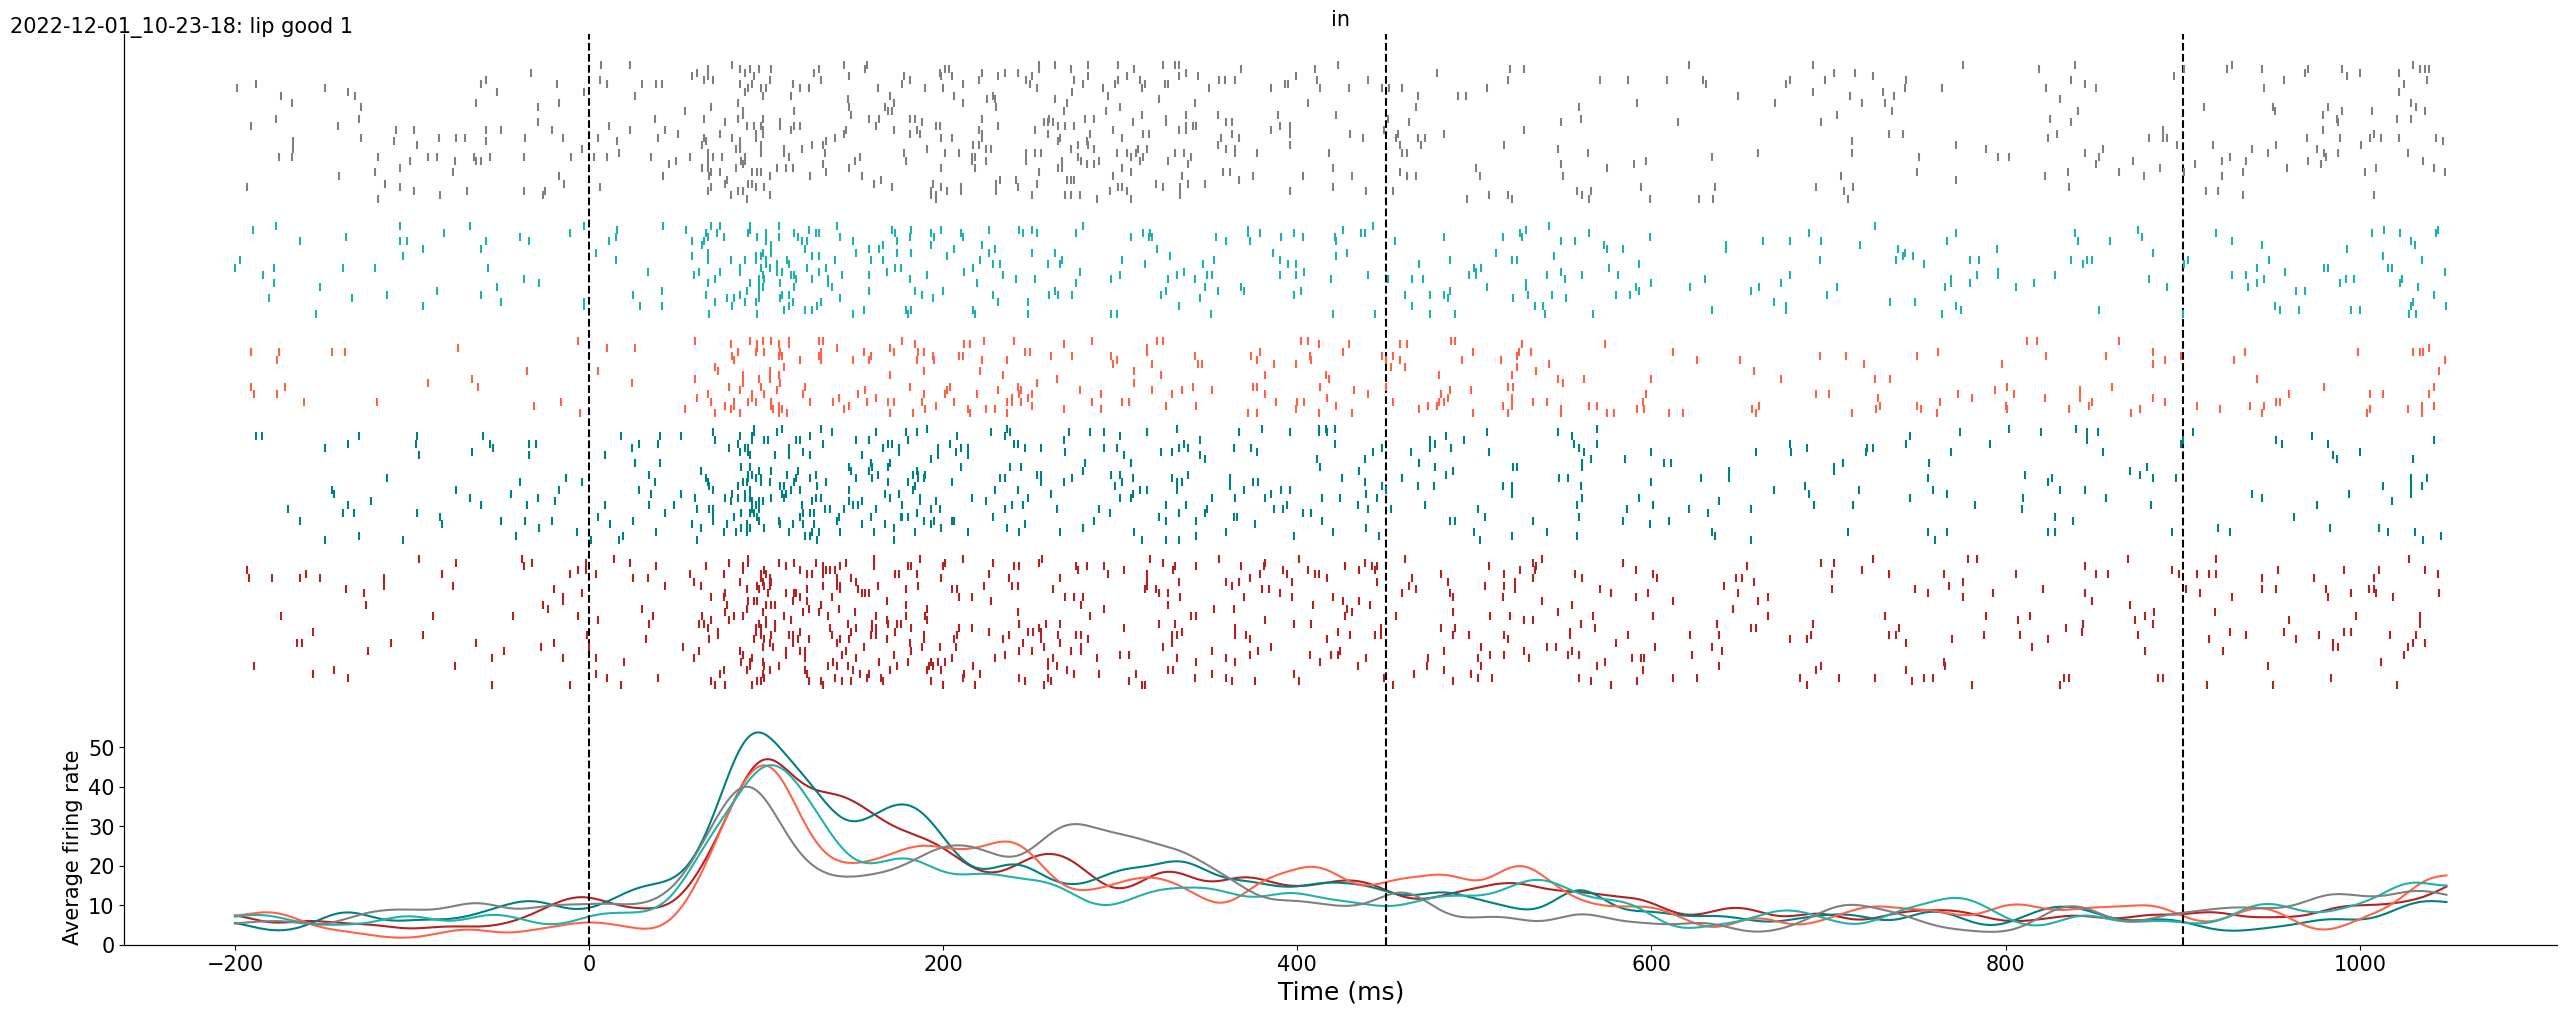

In [37]:
plot_activity(sp_by_sample,start,end,conv_all)

### Select significant trials

In [38]:
trials_conv = firing_rate.convolve_signal(arr=sp_sample_on,fs = 1000,w_size=0.1,w_std=0.015,axis=1)
baseline = trials_conv[:,idx_start:idx_start+200]
trial_act = trials_conv[:,idx_start+200:idx_end]
p_value = stats.f_oneway(baseline, trial_act,axis=1)[1]
zero_bl = np.logical_and(np.isnan(p_value), np.sum(trial_act,axis=1)!=0)
sig_trials = np.logical_or(zero_bl, p_value<0.05)

/tmp/ipykernel_7258/1034607615.py:4: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  p_value = stats.f_oneway(baseline, trial_act,axis=1)[1]


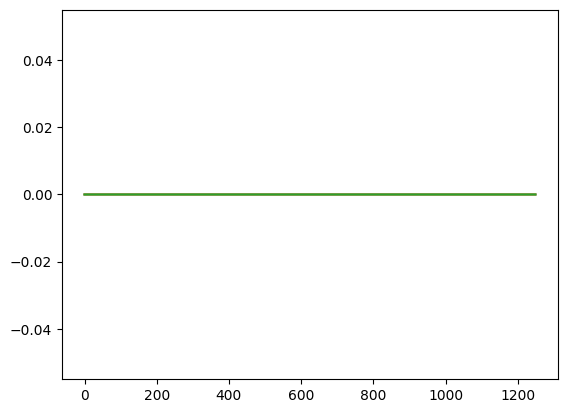

In [39]:
_=plt.plot(trials_conv[sig_trials==False,idx_start:idx_end][5:8].T)

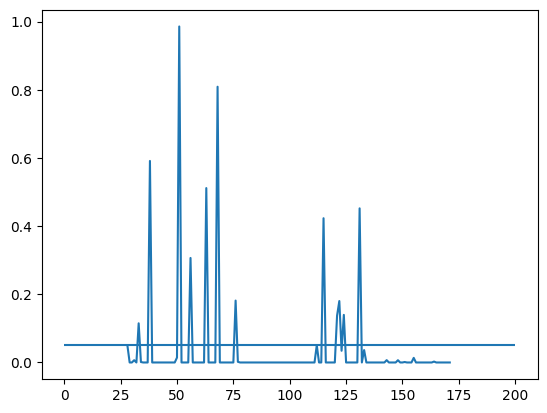

In [40]:
plt.plot(p_value)
plt.hlines(0.05,0,200)

In [41]:
sp_by_sample = select_trials.get_sp_by_sample(sp_sample_on[sig_trials],sample_id[sig_trials])
for key,value in sp_by_sample.items():
    arr = value.mean(axis=0)
    conv = firing_rate.convolve_signal(arr=arr,fs = 1000,w_size=0.1,w_std=0.015,axis=0)[idx_start:idx_end]
    conv_all[key] = conv
    sp_by_sample[key]=value[:,idx_start:idx_end]
    count_trials= value.shape[0]
    max_conv = np.max(conv) 
    all_max_conv = max_conv if max_conv > all_max_conv else all_max_conv
    all_max_trial = count_trials if count_trials > all_max_trial else all_max_trial
all_sp_by_sample = sp_by_sample

In [42]:
max_conv

45.50098265461994

/tmp/ipykernel_7258/1953733509.py:8: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(cols+start,rows+n_trials, marker='|', alpha=1,edgecolors='none',color=colors[key],label="sample %s" % key)


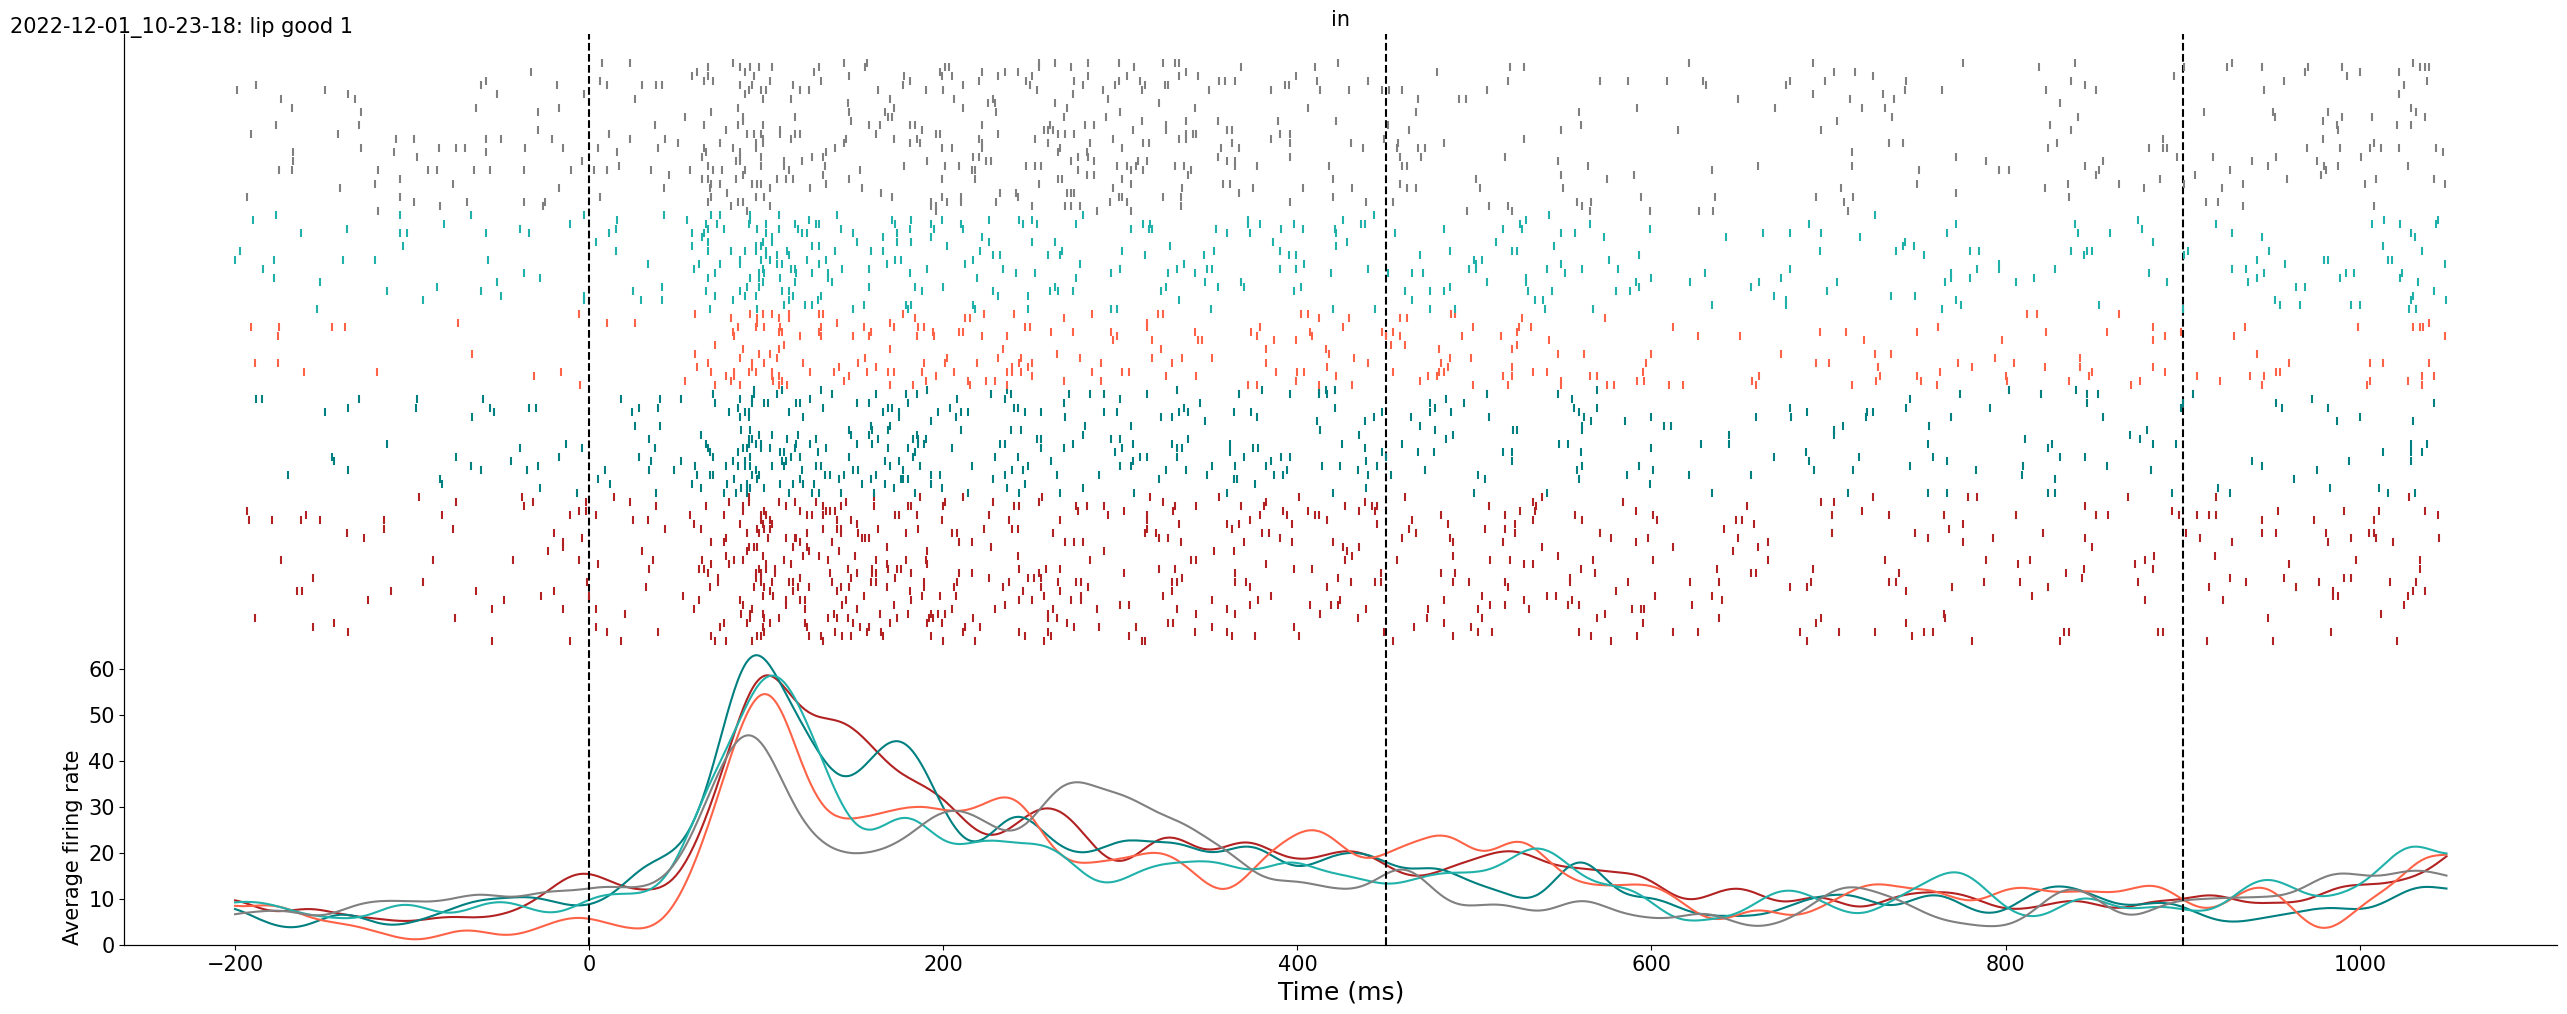

In [43]:
plot_activity(sp_by_sample,start,end,conv_all)

In [44]:

def check_epochs_activity(signal:np.ndarray,dur_bl:int,st_1:int,end_1:int,st_2:int,end_2:int):
    if signal.shape[0] > min_trials:
        mean_1 = signal[:, dur_bl + st_1 : dur_bl + end_1].mean(axis=1)
        mean_2 = signal[:, dur_bl + st_2 : dur_bl + end_2].mean(axis=1)
        mean_bl = signal[:, :dur_bl].mean(axis=1)

        larger_1 = mean_bl.mean() < mean_1.mean()
        larger_2 = mean_bl.mean() < mean_2.mean()

        # paired sample t-test: compare baseline vs epochs
        p_1 = stats.ttest_rel(mean_bl, mean_1)[1]
        p_2 = stats.ttest_rel(mean_bl, mean_2)[1]
    else:
        larger_1,larger_2 = False,False
        p_1,p_2 = np.nan, np.nan
    return larger_1,larger_2,p_1,p_2


In [45]:
v_larger_in,d_larger_in,p_v_in,p_d_in = check_epochs_activity(sp_sample_on_in,dur_fix,st_v,end_v,st_d,end_d)
v_larger_out,d_larger_out,p_v_out,p_d_out = check_epochs_activity(sp_sample_on_out,dur_fix,st_v,end_v,st_d,end_d)

NameError: name 'sp_sample_on_in' is not defined

In [ ]:
check_in = np.logical_and(np.logical_or(v_larger_in,d_larger_in),np.logical_or(p_v_in<p_threshold,p_d_in<p_threshold))
check_out = np.logical_and(np.logical_or(v_larger_out,d_larger_out),np.logical_or(p_v_out<p_threshold,p_d_out<p_threshold))
if check_in:
    rf = 'in'
    significant = True
elif check_out:
    rf='out'
    significant = True
else:
    rf='in'
    significant = False
    

#### Compute VD index

In [ ]:
if rf == 'in':
    sp = sp_sample_on_in
elif rf == 'out':
    sp = sp_sample_on_out
if significant:
    mean_visual = sp[:, dur_fix + st_v : dur_fix + end_v].mean()
    mean_delay = sp[:, dur_fix + st_d : dur_fix + end_d].mean()
    max_fr = sp[:,  : dur_fix + end_d].mean()
    mean_delay = mean_delay / max_fr  
    mean_visual = mean_visual / max_fr  
    vd_index = (mean_delay - mean_visual) / (mean_delay + mean_visual)
else:
    vd_index=np.nan

In [ ]:
vd_index

-0.18008142812402123

In [ ]:
# neu_data.vd_index=vd_index
# neu_data.to_python_hdf5('ddd.h5')
# dd = NeuronData.from_python_hdf5('ddd.h5')